In [1]:
import os, sys
sys.path.append("/home/alexanderalbizu")
sys.path.append("/home/alexanderalbizu/.local/bin")
os.environ["WANDB_NOTEBOOK_NAME"] = "CNN.ipynb"
#!python setup.py develop 
# !pip install wandb
# !pip install 'monai[all]'
#!pip -q install vit_pytorch
#!pip -q install linformer

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob, math, os, shutil, tempfile, time, monai, torch, random

import wandb as wb
from enum import Enum
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from monai.networks.utils import eval_mode
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    ImageDataset,
    Dataset,
    decollate_batch,
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from vit_pytorch.efficient import ViT
from linformer import Linformer
from sklearn.model_selection import train_test_split
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.transforms import (
    AddChannel,
    Compose,
    RandGaussianNoise,
    Resize,
    RemoveRepeatedChannel,
    Orientation,
    RandRotate90,
    RandBiasField,
    ScaleIntensity,
    ToDevice,
    EnsureType,
)
from monai.utils import set_determinism

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print_config()
wb.login(); # 7e5f63e5846f29b034d98806712ab047df76834d

MONAI version: 0.8.1+324.g1269f0ca.dirty
Numpy version: 1.20.1
Pytorch version: 1.9.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1269f0ca0c275f462536c0087e85b074ce480e2e
MONAI __file__: /home/alexanderalbizu/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 9.1.1
Tensorboard version: 1.15.0+nv
gdown version: 4.4.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



wandb: Currently logged in as: aalbizu. Use `wandb login --relogin` to force relogin


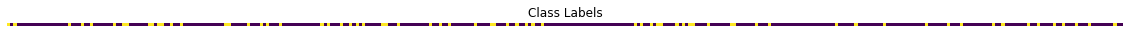

In [3]:
# Set data directory
rootDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/';
sdata = pd.read_csv(os.path.join(rootDir,'subjects_pre-mci_classification.csv')).to_numpy();
train_batch = 150; val_batch=13; test_batch=5;
im_size = (64,64,64)
# pat_size = (24,24,24)
grad_clip = 2
step_size = 1
gamma = 7e-1
seed = 42

# Two binary labels for Healthy vs pre-MCI
lab = np.array([sdata[:,1]]);

class Diagnosis(Enum):
    normal = 0
    preMCI = 1

# Plot Labels
plt.rcParams['figure.figsize'] = [20, 20]; plt.imshow(lab); 
plt.axis('off'); plt.title('Class Labels');

sub-100161 (1/349) T1 Data
(181, 217, 181)


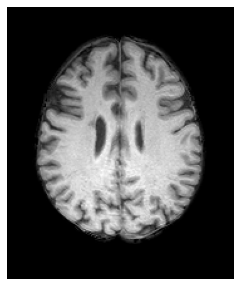

In [4]:
images = [os.path.join(rootDir,'anat',''.join(['wc0csub-',str(sdata[s,0]),'_ses-01_T1w.nii'])) for s in range(sdata.shape[0])];

# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
    
# seed_everything(seed)    

nontest_list, test_list = train_test_split(images, 
                                          test_size=0.03,
                                          stratify=lab.T,
                                          random_state=seed)
nontest_label, test_label = train_test_split(lab.T, 
                                          test_size=0.03,
                                          stratify=lab.T,
                                          random_state=seed)
train_list, valid_list = train_test_split(nontest_list, 
                                          test_size=0.12,
                                          stratify=nontest_label,
                                          random_state=seed)
train_label, valid_label = train_test_split(nontest_label, 
                                          test_size=0.12,
                                          stratify=nontest_label,
                                          random_state=seed); 
del nontest_list, nontest_label; # Save RAM

# Plot Responder Mean
plt.rcParams['figure.figsize'] = [5,5];
np.disp(''.join(['sub-',str(sdata[0,0]),' (1/',str(sdata.shape[0]),') T1 Data']));
nii = nib.load(images[0]); print(nii.shape) # Load Each Electrode
plt.imshow(nii.get_fdata()[:, :, 100].T, cmap="gray", origin="lower"); plt.axis('off'); # Plot

torch.Size([1, 1, 64, 64, 64]) tensor([[[0, 1]]]) torch.Size([1, 1, 2])


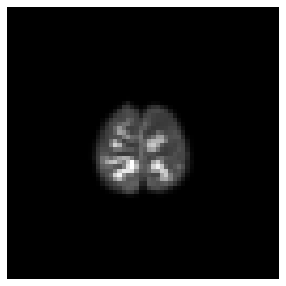

In [5]:
# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(lab.T)).long();
train_lab = torch.nn.functional.one_hot(torch.as_tensor(train_label.T)).long(); 
valid_lab = torch.nn.functional.one_hot(torch.as_tensor(valid_label.T)).long();

# Define transforms
train_transforms = Compose([
    ScaleIntensity(minv=0.0, maxv=1.0),
    AddChannel(),
    Resize(im_size),
    RandBiasField(),
    RandGaussianNoise(), 
    EnsureType(data_type='tensor')]);

val_transforms = Compose([
    ScaleIntensity(minv=0.0, maxv=1.0),
    AddChannel(),
    Resize(im_size),
    EnsureType(data_type='tensor')]);

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms);
check_loader = DataLoader(check_ds, batch_size=1, num_workers=2, pin_memory=pin_memory);

im, label = monai.utils.misc.first(check_loader); print(im.shape, label, label.shape)
plt.imshow(im[0,0,:,:,35].T, cmap="gray", origin="lower"); plt.axis('off'); del check_ds, check_loader, im, label;

In [6]:
# create a training data loader
train_ds = ImageDataset(image_files=train_list, labels=train_lab[0,:,:], transform=train_transforms);
train_loader = DataLoader(train_ds, batch_size=train_batch, shuffle=True, num_workers=4, pin_memory=pin_memory);

# create a validation data loader
val_ds = ImageDataset(image_files=valid_list, labels=valid_lab[0,:,:], transform=val_transforms);
val_loader = DataLoader(val_ds, batch_size=val_batch, num_workers=4, pin_memory=pin_memory)

In [9]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=2).to(device)
# model = monai.networks.nets.ViT(spatial_dims=3, in_channels=1, img_size=im_size, patch_size=pat_size, classification=True).to(device)
# efficient_transformer = Linformer(
#     dim=128,
#     seq_len=49+1,  # 7x7 patches + 1 cls-token
#     depth=12,
#     heads=8,
#     k=64
# )

# model = ViT(
#     dim=128,
#     image_size=96,
#     patch_size=32,
#     num_classes=2,
#     transformer=efficient_transformer,
#     channels=1,
# ).to(device)

# loss_function
# loss_fx = torch.nn.BCELoss() 
loss_fx = torch.nn.BCEWithLogitsLoss() 
# loss_fx = torch.nn.SoftMarginLoss()  
# loss_fx = torch.nn.HingeEmbeddingLoss()
# loss_fx = torch.nn.HuberLoss()
#loss_fx = torch.nn.CrossEntropyLoss() 

lr = 1e-5
wd = 0

# start a typical PyTorch training
val_interval = 1
epoch_loss_values = [] # Pre-Allocate
epoch_acc_values = [] # Pre-Allocate
max_epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

wb.init(project="ACT-CNN",
           config={
               "batch_size": train_batch,
               "val_batch": val_batch,
               "test_batch": test_batch,
               "image_size": im_size,
               "gradient_clip": grad_clip,
               "learning_rate": lr,
               "step_size": step_size,
               "gamma": gamma,
               "weight_decay": wd,
               "dataset": "ACT",
           })
wb.watch(model, log='all')

# auc_metric = monai.metrics.ROCAUCMetric()
scaler = torch.cuda.amp.GradScaler()
for epoch in range(max_epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_data in train_loader:
        inputs, label = batch_data[0].to(device), batch_data[1].to(device);
        
        # Evaluate Model
        output = model(inputs);
        loss = loss_fx(output, label.float())
        
        # Update Gradient
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # Evaluate Model
            output = model(inputs);
            loss = loss_fx(output, label.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Gradient Norm Clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip, norm_type=2)

        #Gradient Value Clipping
#         torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=grad_clip)
#         optimizer.step()
        
        # Accuracy
        acc = (output.argmax(dim=1) == label.argmax(dim=1)).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_acc_values.append(acc)
        
        # Loss
        epoch_loss += loss / len(train_loader)
        epoch_loss_values.append(epoch_loss)
        print(f"train loss: {loss.item():.4f}")
        wb.log({'train_loss': loss, 'train_acc': acc})

    with eval_mode(model):
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
            
            val_output = model(val_images)
            val_loss = loss_fx(val_output, val_labels.float())

            val_acc = (val_output.argmax(dim=1) == val_labels.argmax(dim=1)).float().mean()
            epoch_val_accuracy += val_acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)
            wb.log({'val_loss': val_loss, 'val_acc': val_acc})

    print(
        f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
wb.run.log_code(".")
wb.finish()

train loss: 0.6556
train loss: nan
train loss: 0.6470
Epoch : 1 - train_loss : nan - train_acc: 0.7876 - val_loss : nan - val_acc: 0.8462

train loss: 0.6281
train loss: nan
train loss: 0.6125
Epoch : 2 - train_loss : nan - train_acc: 0.8015 - val_loss : nan - val_acc: 0.8462

train loss: 0.6135
train loss: nan
train loss: 0.6011
Epoch : 3 - train_loss : nan - train_acc: 0.7981 - val_loss : nan - val_acc: 0.8462

train loss: 0.5773
train loss: 0.5837
train loss: nan
Epoch : 4 - train_loss : nan - train_acc: 0.7978 - val_loss : nan - val_acc: 0.8462

train loss: nan
train loss: 0.5810
train loss: 0.5616
Epoch : 5 - train_loss : nan - train_acc: 0.7980 - val_loss : nan - val_acc: 0.8462



train_acc,▁█▂▄▄▆▂▅▆▇▃▃▆▂▅
train_loss,█ ▇▆ ▅▅ ▄▂▃ ▂▁
val_acc,▁▁▃█▁▁▃█▁▁▃█▁▁▃█▁▁▃█
train_acc,0.80412
train_loss,0.56157
val_acc,1.0
val_loss,nan


In [19]:
# print(epoch_loss_values.numpy())
# plt.plot(epoch_loss_values, label="training loss")
# val_epochs = np.linspace(
#     1, max_epochs, np.floor(max_epochs / val_interval).astype(np.int32)
# )
# plt.plot(val_epochs, val_acc, label="validation acc")
# plt.legend()
# plt.xlabel("Epoch")
# plt.ylabel("Value")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# # Plotting
# fig, ax = plt.subplots(1, 1, facecolor='white')
# ax.set_xlabel('Epoch')
# ax.set_ylabel('Metrics')
# plt.ion()
# fig.show()
# fig.canvas.draw()
# ax.clear()
# train_epochs = np.linspace(1, max_epochs, max_epochs)
# ax.plot(train_epochs, epoch_loss_values, label='loss')
# ax.plot(train_epochs, epoch_acc_values, label='ACC')
# ax.set_xlabel('Epoch')
# ax.set_ylabel('Metrics')
# ax.legend()
# fig.canvas.draw()

              precision    recall  f1-score   support

      normal       0.82      1.00      0.90         9
      preMCI       0.00      0.00      0.00         2

    accuracy                           0.82        11
   macro avg       0.41      0.50      0.45        11
weighted avg       0.67      0.82      0.74        11



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


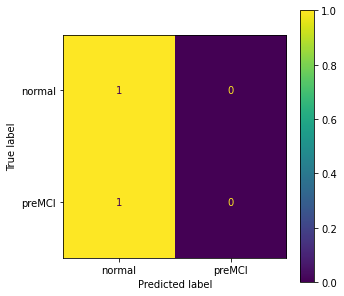

In [20]:
# create a validation data loader
test_ds = ImageDataset(image_files=test_list, labels=test_label, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=test_batch, num_workers=4, pin_memory=pin_memory)

with eval_mode(model):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(
            device), test_data[1].to(device)

        outputs = model(test_images)
        y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
        y = torch.cat([y, test_labels], dim=0)

print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true')

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis])

disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Occulusion Sensitivity

original feature shape torch.Size([1, 1, 2, 2, 2])
upsampled feature shape [1, 1, 64, 64, 64]


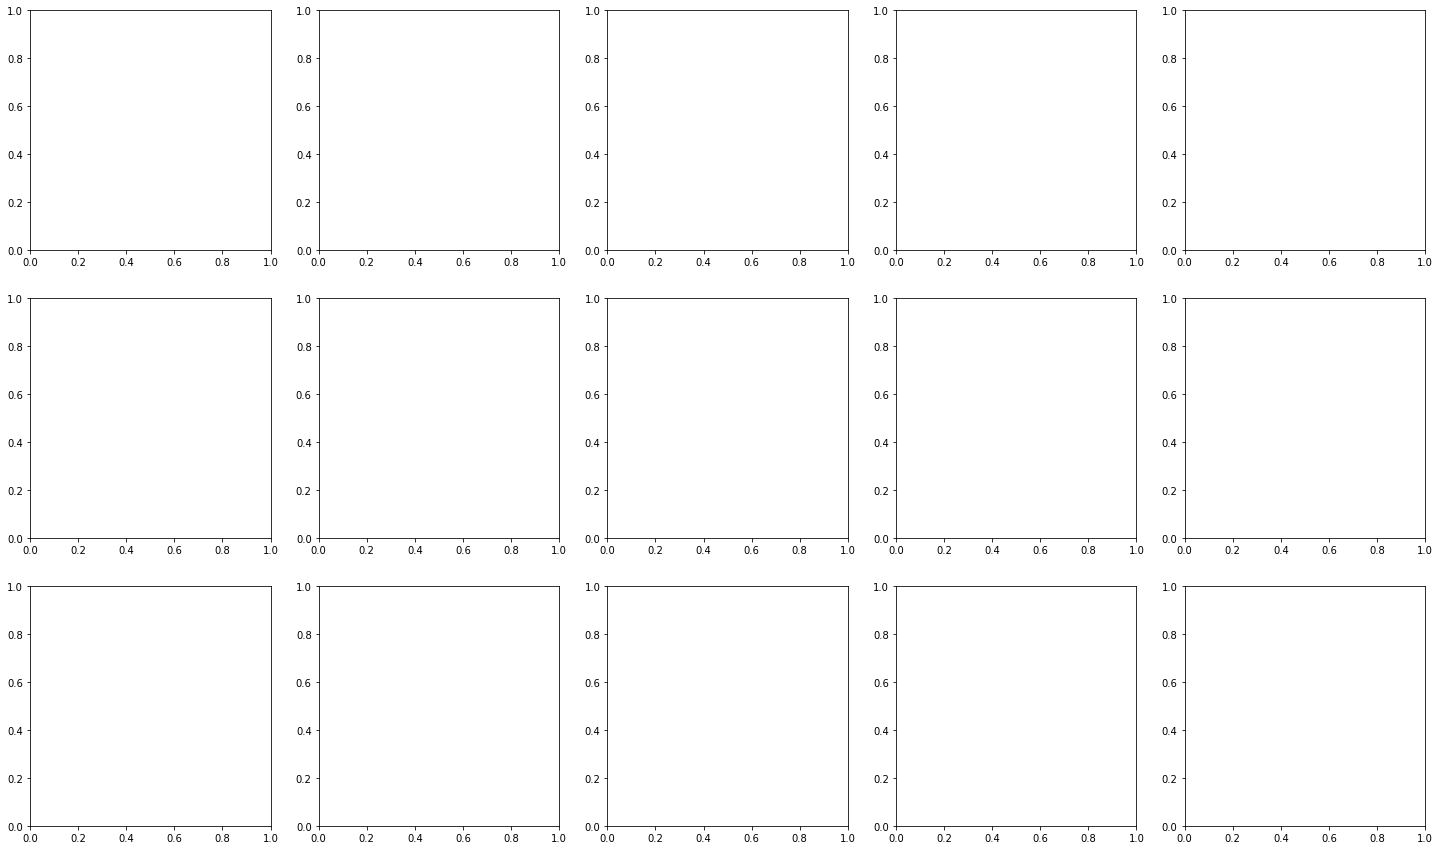

In [23]:
# cam = monai.visualize.CAM(nn_module=model_3d, target_layers="class_layers.relu", fc_layers="class_layers.out")
cam = monai.visualize.GradCAM(
    nn_module=model, target_layers="class_layers.relu"
)
# cam = monai.visualize.GradCAMpp(nn_module=model_3d, target_layers="class_layers.relu")
print(
    "original feature shape",
    cam.feature_map_size([1, 1] + list(im_size), device),
)
print("upsampled feature shape", [1, 1] + list(im_size))

occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=1, stride=28
)

# For occlusion sensitivity, inference must be run many times. Hence, we can use a
# bounding box to limit it to a 2D plane of interest (z=the_slice) where each of
# the arguments are the min and max for each of the dimensions (in this case CHWD).
the_slice = train_ds[0][0].shape[-1] // 2
occ_sens_b_box = [-1, -1, -1, -1, -1, -1, the_slice, the_slice]

train_transforms.set_random_state(42)
n_examples = 5
subplot_shape = [3, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(25, 15), facecolor="white")
items = np.random.choice(len(train_ds), size=len(train_ds), replace=False)

example = 0
for item in items:

    data = train_ds[
        item
    ]  # this fetches training data with random augmentations
    image, label = data[0].to(device).unsqueeze(0), data[1][1]
    y_pred = model(image)
    pred_label = y_pred.argmax(1).item()
    # Only display preMCI
    if label != 1 or label != pred_label:
        continue

    img = image.detach().cpu().numpy()[..., the_slice]

    name = "actual: "
    name += "preMCI" if label == 1 else "healthy"
    name += "\npred: "
    name += "preMCI" if pred_label == 1 else "healthy"
    name += f"\npreMCI: {y_pred[0,1]:.3}"
    name += f"\nhealthy: {y_pred[0,0]:.3}"

    # run CAM
    cam_result = cam(x=image, class_idx=None)
    cam_result = cam_result[..., the_slice]

    # run occlusion
    occ_result, _ = occ_sens(x=image, b_box=occ_sens_b_box)
    occ_result = occ_result[..., pred_label]

    for row, (im, title) in enumerate(
        zip(
            [img, cam_result, occ_result],
            [name, "CAM", "Occ. sens."],
        )
    ):
        cmap = "gray" if row == 0 else "jet"
        ax = axes[row, example]
        if isinstance(im, torch.Tensor):
            im = im.cpu().detach()
        im_show = ax.imshow(im[0][0], cmap=cmap)

        ax.set_title(title, fontsize=25)
        ax.axis("off")
        fig.colorbar(im_show, ax=ax)

    example += 1
    if example == n_examples:
        break